C:\Users\aleksey.makarov\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\aleksey.makarov\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\aleksey.makarov\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

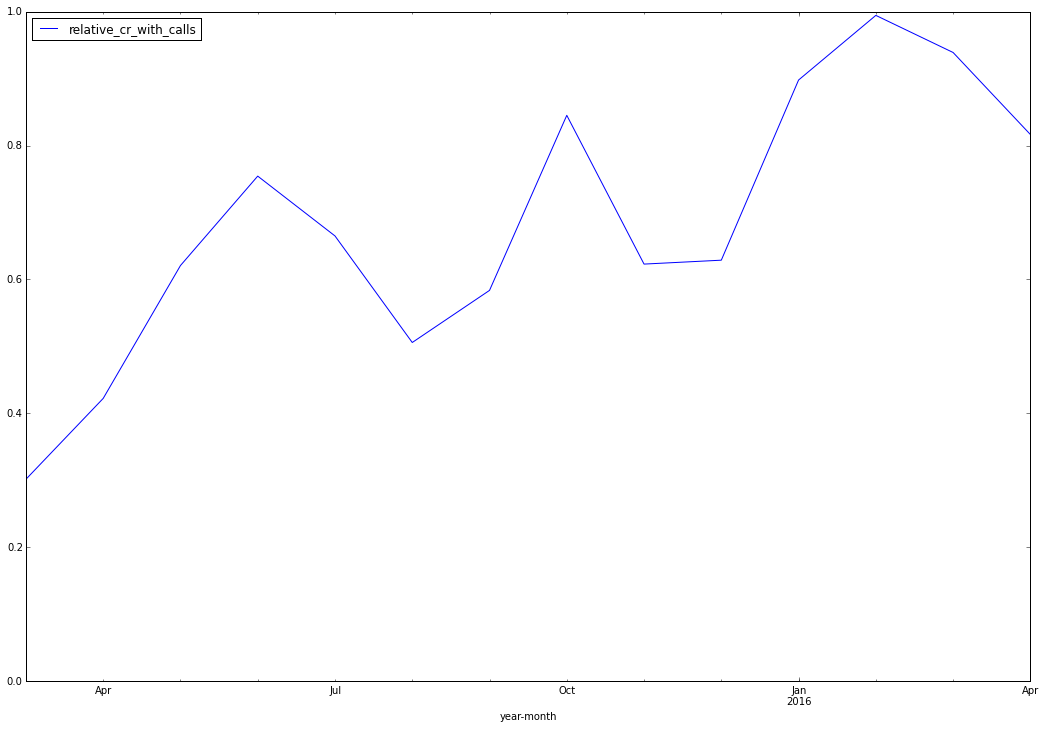

In [1]:
import psycopg2
import pandas as pd
from pandas import ExcelWriter
from datetime import datetime
import matplotlib
import numpy as np
%matplotlib inline
# Из файла получаем запрос
query = ''
with open(u'C:\\Users\\aleksey.makarov\\Desktop\\2016-04\\Отчет по эффективности\\query_3.txt','r+') as f:
    for row in f:
        query+= row
# Получаем данные по запросу
conn = psycopg2.connect("dbname='CuboHistory' user='read_only' host='192.168.10.32' password='User_ro'")
cur = conn.cursor()
cur.execute(query)
result = []
rows = cur.fetchall()
# Данные загоняем в датафрейм
df = pd.DataFrame(rows)
df.columns = ['projectid','domain','user','date','medium','campaign','utmvisits','goals','calls','is_landing','adv_budget','payment_sum']
# Убираем строки, где пустые domain или user или projectid
df2 = df.loc[~pd.isnull(df[['domain','user','projectid']]).any(axis=1)].drop('campaign', axis=1).fillna(0.0).reset_index(drop=True)
# Всякие манипуляции с типами
df3 = df2.copy(deep=True)
df3['user'] = df3['user'].apply(str)
df3['medium'] = df3['medium'].apply(str)
df3['domain'] = df3['domain'].map(lambda x: x.decode('utf8'))
df3['user'] = df3['user'].map(lambda x: x.decode('utf8'))
df3['medium'] = df3['medium'].map(lambda x: x.decode('utf8'))
df3['is_landing'] = df3['is_landing'].map(lambda x: x.decode('utf8'))
df3['adv_budget'] = df3['adv_budget'].astype(float)
df3['payment_sum'] = df3['payment_sum'].astype(float)
# df3['date2'] =  df3['date'].dt.date
df3['date2'] = pd.to_datetime(df3['date'])
# Выделяем в отдельные поля 'year' и 'month' из 'date'
df3['year'] = df3['date2'].dt.year
df3['month'] = df3['date2'].dt.month
# Убираем проекты с девиантными данными ('allomaster.ru','probleck.ru','uniplace.ru',)
df3 = df3[~df3['projectid'].isin([2343427,2325690,2339974,2364034])]
# Суммируем goals + calls в поле 'sum_goals'
df3['sum_goals'] = df3['goals']+df3['calls']

writer = ExcelWriter('D:\\neelova_eff_report3.xlsx')
# Записываем в excel "сырые" данные на вкладку "Raw Data"
df3.to_excel(writer, 'Raw Data')

# Таблица с данными по cubo (по месяцам) в целом

# Выбираем только данные органики, у которых 'medium'=='organic' и группируем их по 'year','month','medium' (в качестве агрегирующей функции используем sum)
month_organic_data = df3[(df3['medium'] == 'organic')].groupby(['year','month','medium'],as_index=False).sum()
# Выбираем только данные cubo, у которых 'medium'!='organic' и группируем их по 'year','month','medium' (в качестве агрегирующей функции используем sum)
month_cubo_data = df3[(df3['medium'] != 'organic')].groupby(['year','month','medium'],as_index=False).sum()
# Убираем из month_cubo_data все данные, где medium in ('direct_context','direct_search') и группируем по 'year' и 'month' (в качестве агрегирующей функции используем sum)
month_grouped_cubo_data = month_cubo_data[~month_cubo_data['medium'].isin(['direct_context','direct_search'])][['year','month','utmvisits','goals','calls','sum_goals']].groupby(['year','month'],as_index=False).sum()
month_organic_data_for_merge = month_organic_data[['year','month','utmvisits','goals','calls','sum_goals']]
# Рассчитываем conversion rate со звонками для данных органики
month_organic_data_for_merge['cr_with_calls'] = month_organic_data_for_merge['sum_goals']/month_organic_data_for_merge['utmvisits']
# Рассчитываем conversion rate со звонками для данных по cubo
month_grouped_cubo_data['cr_with_calls'] = month_grouped_cubo_data['sum_goals']/month_grouped_cubo_data['utmvisits']
# Рассчитываем conversion rate без звонков для данных органики
month_organic_data_for_merge['cr'] = month_organic_data_for_merge['goals']/month_organic_data_for_merge['utmvisits']
# Рассчитываем conversion rate без звонков для данных по cubo
month_grouped_cubo_data['cr'] = month_grouped_cubo_data['goals']/month_grouped_cubo_data['utmvisits']
# Переименовываем колонки в данных органики, добавив префикс organic
month_organic_data_for_merge.rename(columns={'utmvisits':'organic_visits','goals':'organic_goals','calls':'organic_calls','cr':'organic_cr','sum_goals':'organic_sum_goals','cr_with_calls':'organic_cr_with_calls'},inplace=True)
# Объединяем данные органики и cubo по полям 'year' и 'month'
month_results = pd.merge(month_grouped_cubo_data,month_organic_data_for_merge,how='outer',on=['year','month'])
# Рассчитываем relative conversion rate без звонков
month_results['relative_cr'] = month_results['cr']/month_results['organic_cr']
# Рассчитываем relative conversion rate со звонками
month_results['relative_cr_with_calls'] = month_results['cr_with_calls']/month_results['organic_cr_with_calls']
# NA (при делении 0 на 0) заменяем на 0
month_results = month_results.fillna(0.0)
# INF (при делении числа на 0) заменяем на 1
month_results = month_results.replace(np.inf, 1.0)
month_results['year']=month_results['year'].astype(int)
month_results['month']=month_results['month'].astype(int)
for i in xrange(0,len(month_results)):
    month_results.loc[i,'year-month'] = datetime(int(month_results.loc[i,'year']),int(month_results.loc[i,'month']),1)
# Записываем в excel данные по cubo (по месяцам)
month_results.to_excel(writer, 'By Month')
month_results[['year-month','relative_cr_with_calls']][(month_results['year-month'] >= '2015-03-01')].plot(x='year-month',figsize=(18, 12),scaley=0)

# Таблица с данными по каналам и месяцам

# Выбираем только данные органики, у которых 'medium'=='organic' и группируем их по 'year','month','medium' (в качестве агрегирующей функции используем sum)
channel_organic_data = df3[(df3['medium'] == 'organic')].groupby(['year','month','medium'],as_index=False).sum()
# Выбираем только данные cubo, у которых 'medium'!='organic' и группируем их по 'year','month','medium' (в качестве агрегирующей функции используем sum)
channel_cubo_data = df3[(df3['medium'] != 'organic')].groupby(['year','month','medium'],as_index=False).sum()
# Убираем из month_cubo_data все данные, где medium in ('direct_context','direct_search') и группируем по 'year','month' и 'medium' (в качестве агрегирующей функции используем sum)
channel_grouped_cubo_data = channel_cubo_data[~channel_cubo_data['medium'].isin(['direct_context','direct_search'])][['year','month','medium','utmvisits','goals','calls','sum_goals']].groupby(['year','month','medium'],as_index=False).sum()
channel_organic_data_for_merge = channel_organic_data[['year','month','utmvisits','goals','calls','sum_goals']]
# Рассчитываем conversion rate со звонками для данных органики
channel_organic_data_for_merge['cr_with_calls'] = channel_organic_data_for_merge['sum_goals']/channel_organic_data_for_merge['utmvisits']
# Рассчитываем conversion rate со звонками для данных по cubo
channel_grouped_cubo_data['cr_with_calls'] = channel_grouped_cubo_data['sum_goals']/channel_grouped_cubo_data['utmvisits']
# Рассчитываем conversion rate без звонков для данных органики
channel_organic_data_for_merge['cr'] = channel_organic_data_for_merge['goals']/channel_organic_data_for_merge['utmvisits']
# Рассчитываем conversion rate без звонков для данных по cubo
channel_grouped_cubo_data['cr'] = channel_grouped_cubo_data['goals']/channel_grouped_cubo_data['utmvisits']
# Переименовываем колонки в данных органики, добавив префикс organic
channel_organic_data_for_merge.rename(columns={'utmvisits':'organic_visits','goals':'organic_goals','calls':'organic_calls','cr':'organic_cr','sum_goals':'organic_sum_goals','cr_with_calls':'organic_cr_with_calls'},inplace=True)
# Объединяем данные органики и cubo по полям 'year' и 'month'
channel_results = pd.merge(channel_grouped_cubo_data,channel_organic_data_for_merge,how='outer',on=['year','month'])
# Рассчитываем relative conversion rate без звонков
channel_results['relative_cr'] = channel_results['cr']/channel_results['organic_cr']
# Рассчитываем relative conversion rate со звонками
channel_results['relative_cr_with_calls'] = channel_results['cr_with_calls']/channel_results['organic_cr_with_calls']
# NA (при делении 0 на 0) заменяем на 0
channel_results = channel_results.fillna(0.0)
# INF (при делении числа на 0) заменяем на 1
channel_results = channel_results.replace(np.inf, 1.0)
channel_results['year']=channel_results['year'].astype(int)
channel_results['month']=channel_results['month'].astype(int)
for i in xrange(0,len(channel_results)):
    channel_results.loc[i,'year-month'] = datetime(int(channel_results.loc[i,'year']),int(channel_results.loc[i,'month']),1)
# Записываем в excel данные по каналам и месяцам
channel_results.to_excel(writer, 'By Channels')

# Таблица с данными по специалистам и месяцам

# Выбираем только данные органики, у которых 'medium'=='organic' и группируем их по 'year','month','user' (в качестве агрегирующей функции используем sum)
user_organic_data = df3[(df3['medium'] == 'organic')].groupby(['year','month','user'],as_index=False).sum()
# Выбираем только данные cubo, у которых 'medium'!='organic' и группируем их по 'year','month','user','medium' (в качестве агрегирующей функции используем sum)
user_cubo_data = df3[(df3['medium'] != 'organic')].groupby(['year','month','user','medium'],as_index=False).sum()
# Убираем из month_cubo_data все данные, где medium in ('direct_context','direct_search') и группируем по 'year','month' и 'user' (в качестве агрегирующей функции используем sum)
user_grouped_cubo_data = user_cubo_data[~user_cubo_data['medium'].isin(['direct_context','direct_search'])][['year','month','user','utmvisits','goals','calls','sum_goals']].groupby(['year','month','user'],as_index=False).sum()
user_organic_data_for_merge = user_organic_data[['year','month','user','utmvisits','goals','calls','sum_goals']]
# Рассчитываем conversion rate со звонками для данных органики
user_organic_data_for_merge['cr_with_calls'] = user_organic_data_for_merge['sum_goals']/user_organic_data_for_merge['utmvisits']
# Рассчитываем conversion rate со звонками для данных по cubo
user_grouped_cubo_data['cr_with_calls'] = user_grouped_cubo_data['sum_goals']/user_grouped_cubo_data['utmvisits']
# Рассчитываем conversion rate без звонков для данных органики
user_organic_data_for_merge['cr'] = user_organic_data_for_merge['goals']/user_organic_data_for_merge['utmvisits']
# Рассчитываем conversion rate без звонков для данных по cubo
user_grouped_cubo_data['cr'] = user_grouped_cubo_data['goals']/user_grouped_cubo_data['utmvisits']
# Переименовываем колонки в данных органики, добавив префикс organic
user_organic_data_for_merge.rename(columns={'utmvisits':'organic_visits','goals':'organic_goals','calls':'organic_calls','cr':'organic_cr','sum_goals':'organic_sum_goals','cr_with_calls':'organic_cr_with_calls'},inplace=True)
# Объединяем данные органики и cubo по полям 'year','month' и 'user'
user_results = pd.merge(user_grouped_cubo_data,user_organic_data_for_merge,how='outer',on=['year','month','user'])
# Рассчитываем relative conversion rate без звонков
user_results['relative_cr'] = user_results['cr']/user_results['organic_cr']
# Рассчитываем relative conversion rate со звонками
user_results['relative_cr_with_calls'] = user_results['cr_with_calls']/user_results['organic_cr_with_calls']
# NA (при делении 0 на 0) заменяем на 0
user_results = user_results.fillna(0.0)
# INF (при делении числа на 0) заменяем на 1
user_results = user_results.replace(np.inf, 1.0)
user_results['year']=user_results['year'].astype(int)
user_results['month']=user_results['month'].astype(int)
for i in xrange(0,len(user_results)):
    user_results.loc[i,'year-month'] = datetime(int(user_results.loc[i,'year']),int(user_results.loc[i,'month']),1)
# Определяем активных специалистов
user_max_month = user_results['year-month'].max()
for i in xrange(0,len(user_results)):
    if user_results[user_results['user'] == (user_results.loc[i,'user'])]['year-month'].max() == user_max_month:
        user_results.loc[i,'is_active_user'] = True
    else:
        user_results.loc[i,'is_active_user'] = False
# Записываем в excel данные по специалистам и месяцам
user_results.to_excel(writer, 'By Users')
# Записываем в excel данные по активным специалистам и месяцам (колонки 'user','year-month','relative_cr','relative_cr_with_calls')
user_results[user_results['is_active_user'] == True][['user','year-month','relative_cr','relative_cr_with_calls']].to_excel(writer, 'Users Stats')

# Таблица с данными по специалистам, проектам и месяцам

# Выбираем только данные органики, у которых 'medium'=='organic' и группируем их по 'year','month','user' и 'domain' (в качестве агрегирующей функции используем sum)
user_project_organic_data = df3[(df3['medium'] == 'organic')].groupby(['year','month','user','domain'],as_index=False).sum()
# Выбираем только данные cubo, у которых 'medium'!='organic' и группируем их по 'year','month','user','medium' и 'domain' (в качестве агрегирующей функции используем sum)
user_project_cubo_data = df3[(df3['medium'] != 'organic')].groupby(['year','month','user','medium','domain'],as_index=False).sum()
# Убираем из month_cubo_data все данные, где medium in ('direct_context','direct_search') и группируем по 'year','month', 'user' и 'domain' (в качестве агрегирующей функции используем sum)
user_project_grouped_cubo_data = user_project_cubo_data[~user_project_cubo_data['medium'].isin(['direct_context','direct_search'])][['year','month','user','domain','utmvisits','goals','calls','sum_goals']].groupby(['year','month','domain','user'],as_index=False).sum()
user_project_organic_data_for_merge = user_project_organic_data[['year','month','user','domain','utmvisits','goals','calls','sum_goals']]
# Рассчитываем conversion rate со звонками для данных органики
user_project_organic_data_for_merge['cr_with_calls'] = user_project_organic_data_for_merge['sum_goals']/user_project_organic_data_for_merge['utmvisits']
# Рассчитываем conversion rate со звонками для данных по cubo
user_project_grouped_cubo_data['cr_with_calls'] = user_project_grouped_cubo_data['sum_goals']/user_project_grouped_cubo_data['utmvisits']
# Рассчитываем conversion rate без звонков для данных органики
user_project_organic_data_for_merge['cr'] = user_project_organic_data_for_merge['goals']/user_project_organic_data_for_merge['utmvisits']
# Рассчитываем conversion rate без звонков для данных по cubo
user_project_grouped_cubo_data['cr'] = user_project_grouped_cubo_data['goals']/user_project_grouped_cubo_data['utmvisits']
# Переименовываем колонки в данных органики, добавив префикс organic
user_project_organic_data_for_merge.rename(columns={'utmvisits':'organic_visits','goals':'organic_goals','calls':'organic_calls','cr':'organic_cr','sum_goals':'organic_sum_goals','cr_with_calls':'organic_cr_with_calls'},inplace=True)
# Объединяем данные органики и cubo по полям 'year','month', 'user', 'domain'
user_project_results = pd.merge(user_project_grouped_cubo_data,user_project_organic_data_for_merge,how='outer',on=['year','month','user','domain'])
# Рассчитываем relative conversion rate без звонков
user_project_results['relative_cr'] = user_project_results['cr']/user_project_results['organic_cr']
# Рассчитываем relative conversion rate со звонками
user_project_results['relative_cr_with_calls'] = user_project_results['cr_with_calls']/user_project_results['organic_cr_with_calls']
# NA (при делении 0 на 0) заменяем на 0
user_project_results = user_project_results.fillna(0.0)
# INF (при делении числа на 0) заменяем на 1
user_project_results = user_project_results.replace(np.inf, 1.0)
user_project_results['year']=user_project_results['year'].astype(int)
user_project_results['month']=user_project_results['month'].astype(int)
for i in xrange(0,len(user_project_results)):
    user_project_results.loc[i,'year-month'] = datetime(int(user_project_results.loc[i,'year']),int(user_project_results.loc[i,'month']),1)
# Определяем активные проекты
project_max_month = user_project_results['year-month'].max()
for i in xrange(0,len(user_project_results)):
    if user_project_results[user_project_results['domain'] == (user_project_results.loc[i,'domain'])]['year-month'].max() == user_max_month:
        user_project_results.loc[i,'is_active_project'] = True
    else:
        user_project_results.loc[i,'is_active_project'] = False
# Записываем в excel данные по специалистам, проектам и месяцам на вкладку 'By Projects'
user_project_results.to_excel(writer, 'By Projects')

# Таблица с эффективностью, взвешенной по бюджету

# Выбираем только данные органики, у которых 'medium'=='organic' и группируем их по 'year','month','user' и 'domain' (в качестве агрегирующей функции используем sum)
budget_organic_data = df3[(df3['medium'] == 'organic')].groupby(['year','month','domain'],as_index=False).sum()
# Выбираем только данные cubo, у которых 'medium'!='organic' и группируем их по 'year','month','user','medium' и 'domain' (в качестве агрегирующей функции используем sum)
budget_cubo_data = df3[(df3['medium'] != 'organic')].groupby(['year','month','medium','domain'],as_index=False).sum()
# Убираем из month_cubo_data все данные, где medium in ('direct_context','direct_search') и группируем по 'year','month', 'user' и 'domain' (в качестве агрегирующей функции используем sum)
budget_grouped_cubo_data = budget_cubo_data[~budget_cubo_data['medium'].isin(['direct_context','direct_search'])][['year','month','domain','utmvisits','goals','calls','sum_goals','adv_budget']].groupby(['year','month','domain'],as_index=False).sum()
budget_organic_data_for_merge = budget_organic_data[['year','month','domain','utmvisits','goals','calls','sum_goals']]
# Переименовываем колонки в данных органики, добавив префикс organic
budget_organic_data_for_merge.rename(columns={'utmvisits':'organic_visits','goals':'organic_goals','calls':'organic_calls','cr':'organic_cr','sum_goals':'organic_sum_goals','cr_with_calls':'organic_cr_with_calls'},inplace=True)
# Объединяем данные органики и cubo по полям 'year','month','domain'
budget_merge = pd.merge(budget_grouped_cubo_data,budget_organic_data_for_merge,how='left',on=['year','month','domain'])
# Получаем таблицу усредненных бюджетов по месяцам: группируем данные колонок 'adv_budget','year','month' по колонкам 'year' и 'month', используя агрегирующую функцию mean
budget_month_data = budget_merge[['adv_budget','year','month']].groupby(['year','month'],as_index=False).mean().rename(columns={'adv_budget':'mean_budget'})
# Объединяем таблицу budget_merge с таблицей усредненных бюджетов по колонкам 'year','month'
budget_merge = pd.merge(budget_merge,budget_month_data,how='left',on=['year','month'])
# Рассчитываем взвешенные визиты cubo
budget_merge['weighted_visits'] = budget_merge['utmvisits']*budget_merge['adv_budget']/budget_merge['mean_budget']
# Рассчитываем взвешенные выполнения целей cubo
budget_merge['weighted_goals'] = budget_merge['sum_goals']*budget_merge['adv_budget']/budget_merge['mean_budget']
# Рассчитываем взвешенные визиты по органике
budget_merge['weighted_organic_visits'] = budget_merge['organic_visits']*budget_merge['adv_budget']/budget_merge['mean_budget']
# Рассчитываем взвешенные выполнения целей по органике
budget_merge['weighted_organic_goals'] = budget_merge['organic_sum_goals']*budget_merge['adv_budget']/budget_merge['mean_budget']
# Рассчитываем коэффициент конверсии cubo
budget_merge['cr_with_calls'] = budget_merge['sum_goals']/budget_merge['utmvisits']
# Рассчитываем коэффициент конверсии органики
budget_merge['organic_cr_with_calls'] = budget_merge['organic_sum_goals']/budget_merge['organic_visits']
# Рассчитываем относительный коэффициент конверсии
budget_merge['relative_cr_with_calls'] = budget_merge['cr_with_calls']/budget_merge['organic_cr_with_calls']
# NA (при делении 0 на 0) заменяем на 0
budget_merge = budget_merge.fillna(0.0)
# INF (при делении числа на 0) заменяем на 1
budget_merge = budget_merge.replace(np.inf, 1.0)
# Записываем в excel таблицу эффективности проектов по бюджету на лист 'Budget Eff By Projects'
for i in xrange(0,len(budget_merge)):
    budget_merge.loc[i,'year-month'] = datetime(int(budget_merge.loc[i,'year']),int(budget_merge.loc[i,'month']),1)
budget_merge.to_excel(writer, 'Budget Eff By Projects')
# Группируем данные таблицы budget_merge по 'year','month', оставив колонки 'weighted_visits','weighted_goals','weighted_organic_visits','weighted_organic_goals' (агрег. функция - sum)
budget_results = budget_merge[['year','month','weighted_visits','weighted_goals','weighted_organic_visits','weighted_organic_goals']].groupby(['year','month'],as_index=False).sum()
# Рассчитываем коэффициент конверсии cubo
budget_results['cr_with_calls'] = budget_results['weighted_goals']/budget_results['weighted_visits']
# Рассчитываем коэффициент конверсии органики
budget_results['organic_cr_with_calls'] = budget_results['weighted_organic_goals']/budget_results['weighted_organic_visits']
# Рассчитываем относительный коэффициент конверсии
budget_results['relative_cr_with_calls'] = budget_results['cr_with_calls']/budget_results['organic_cr_with_calls']
# NA (при делении 0 на 0) заменяем на 0
budget_results = budget_results.fillna(0.0)
# INF (при делении числа на 0) заменяем на 1
budget_results = budget_results.replace(np.inf, 1.0)
for i in xrange(0,len(budget_results)):
    budget_results.loc[i,'year-month'] = datetime(int(budget_results.loc[i,'year']),int(budget_results.loc[i,'month']),1)
# Записываем в excel таблицу эффективности месяцев по бюджету на лист 'Budget Eff By Month'
budget_results.to_excel(writer, 'Budget Eff By Month')

# Таблица по кластерам

# Копируем таблицу по проектам, заменив NA на 0
results_with_span = user_project_results.fillna(0.0)
# Для каждого проекта в каждом месяце определяем интервал, в который попадает 'relative_cr'
for i in xrange(0,len(results_with_span)):
    if results_with_span.loc[i,'relative_cr_with_calls'] <= 0.25:
        results_with_span.loc[i,'span'] = '0-25'
    elif results_with_span.loc[i,'relative_cr_with_calls'] <= 0.5:
        results_with_span.loc[i,'span'] = '25-50'
    elif results_with_span.loc[i,'relative_cr_with_calls'] <= 0.75:
        results_with_span.loc[i,'span'] = '50-75'
    elif results_with_span.loc[i,'relative_cr_with_calls'] <= 1:
        results_with_span.loc[i,'span'] = '75-100'
    else:
        results_with_span.loc[i,'span'] = '>100'
# Записываем в excel данные проектов и месяцев с интервалами на вкладку 'Clustering (Data)'
results_with_span.to_excel(writer, 'Clustering (Data)')
# Группируем данные по интервалу и месяцу, используя в качестве агрегирующей функции count
agr_data_with_span = results_with_span[['span','year-month','domain']].groupby(['span','year-month'],as_index=False).count()
# Создаем сводную таблицу: значение - количество доменов, в строках - месяц и год, в колонках - интервал, в который попал проект
pivot = pd.pivot_table(agr_data_with_span, values='domain', index=['year-month'], columns=['span'], aggfunc=np.sum, margins=True).fillna(0)
# Записываем в excel сводную таблицу по количеству проектов, которые попали в тот или иной интервал на вкладку 'Clustering (Count Pivot)'
pivot.to_excel(writer, 'Clustering (Count Pivot)')
# Рассчитываем в сводной таблице процент количества проектов, попавших в интервал, относительно общего числа проектов в месяце 
table2 = pivot.div( pivot.iloc[:,-1], axis=0 )
# Записываем в excel сводную таблицу по относительному числу проектов в интервалах на вкладку 'Clustering (Percent Pivot)'
table2.to_excel(writer, 'Clustering (Percent Pivot)')

# Аналитика проектов

project_analytics_data = user_project_results[['domain','user','year-month','utmvisits','sum_goals','organic_visits','organic_sum_goals','relative_cr_with_calls']]
# Выбираем только активные проекты
project_analytics_data = user_project_results[user_project_results['is_active_project'] == True][['domain','user','year-month','relative_cr_with_calls']]
# Сортируем по домену и месяцу
project_analytics_data.sort_values(['domain','year-month'],inplace=True)
project_analytics_data.reset_index(inplace=True,drop=True)
# Для каждой строки данных
for i in xrange(0,len(project_analytics_data)):
    # Если первая строка, то значение поля 'happens' = 'first_month'
    if i == 0:
        project_analytics_data.loc[i,'happens'] = 'first_month'
    # Иначе
    else:
        # Если домен на строке не соответствует домену предыдущей строки, то 'happens' = 'first_month'
        if project_analytics_data.loc[i,'domain'] != prev_domain:
            project_analytics_data.loc[i,'happens'] = 'first_month'
        # Иначе
        else:
            # Если значение relative_cr_with_calls на текущей и предыдущей строке = 0, то 'happens' = 'nulls'
            if (project_analytics_data.loc[i,'relative_cr_with_calls'] == 0) and (prev_relative_cr_with_calls == 0):
                project_analytics_data.loc[i,'happens'] = 'nulls'
            # Если значение relative_cr_with_calls на текущей строке больше предыдущего, то 'happens' = 'plus'
            elif (project_analytics_data.loc[i,'relative_cr_with_calls'] > prev_relative_cr_with_calls):
                project_analytics_data.loc[i,'happens'] = 'plus'
            # Если значение relative_cr_with_calls на текущей строке больше предыдущего, то 'happens' = 'minus'
            elif (project_analytics_data.loc[i,'relative_cr_with_calls'] < prev_relative_cr_with_calls):
                project_analytics_data.loc[i,'happens'] = 'minus'
            # Иначе 'happens' = 'equals'
            else:
                project_analytics_data.loc[i,'happens'] = 'equals'
            project_analytics_data.loc[i,'delta'] = project_analytics_data.loc[i,'relative_cr_with_calls'] - prev_relative_cr_with_calls
    prev_domain = project_analytics_data.loc[i,'domain']
    prev_relative_cr_with_calls = project_analytics_data.loc[i,'relative_cr_with_calls']
# Записываем в excel таблицу аналитики проектов на лист 'Project Analytics'
project_analytics_data.to_excel(writer, 'Project Analytics')

writer.save()